In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()
tf.compat.v1.disable_eager_execution()
tf.compat.v1.random.set_random_seed(1234)

In [2]:
df = pd.read_csv('/Users/gkumargaur/workspace/python/gitprojects/Stock-Prediction-Models/dataset/BTC-sentiment.csv')
df.head()

,timestamp,close,positive,negative
0,2019-08-09T23:00:00,11860.074544,0.672896,0.327104
1,2019-08-09T23:20:00,11872.025879,0.595100,0.404900
2,2019-08-09T23:40:00,11880.504557,0.596702,0.403298
3,2019-08-10T00:00:00,11918.873481,0.577972,0.422028
4,2019-08-10T00:20:00,11937.581272,0.585342,0.414658


## How we gather the data, provided by Bitcurate, bitcurate.com

Because I don't have sentiment data related to stock market, so I will use crpytocurrency data, `BTC/USDT` from binance.

1. close data came from CCXT, https://github.com/ccxt/ccxt, an open source cryptocurrency aggregator.
2. We gather from streaming twitter, crawling hardcoded crpyocurrency telegram groups and Reddit. And we store in Elasticsearch as a single index. We trained 1/4 layers BERT MULTILANGUAGE (200MB-ish, originally 700MB-ish) released by Google on most-possible-found sentiment data on the internet, leveraging sentiment on multilanguages, eg, english, korea, japan. **Actually, it is very hard to found negative sentiment related to bitcoin / btc in large volume.**

How we request using elasticsearch-dsl, https://elasticsearch-dsl.readthedocs.io,
```python
# from index name
s = s.filter(
    'query_string',
    default_field = 'text',
    query = 'bitcoin OR btc',
)
```

We only do text query only contain `bitcoin` or `btc`.

## Consensus introduction

We have 2 questions here when saying about consensus, what happened,

1. to future price if we assumed future sentiment is really positive, near to 1.0 . Eg, suddenly China want to adapt cryptocurrency and that can cause huge requested volumes.
2. to future price if we assumed future sentiment is really negative, near to 1.0 . Eg, suddenly hackers broke binance or any exchanges, or any news that caused wreck by negative sentiment.

**We can use deep-learning to simulate for us!**

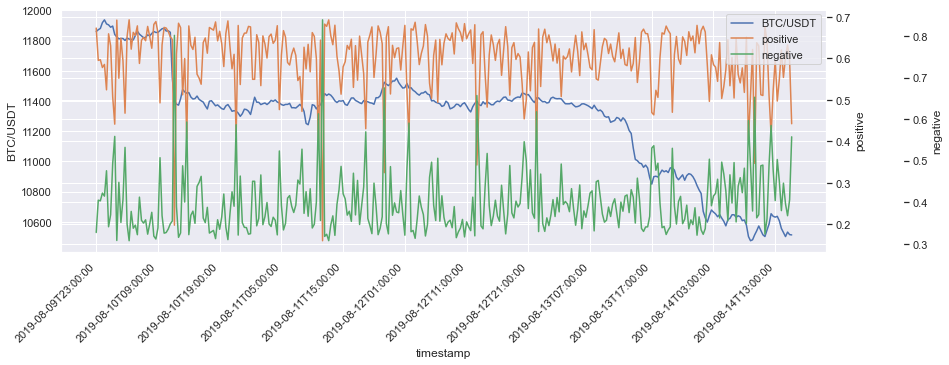

In [3]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

close = df['close'].tolist()
positive = df['positive'].tolist()
negative = df['negative'].tolist()
timestamp = df['timestamp'].tolist()

plt.figure(figsize = (17, 5))
host = host_subplot(111)
plt.subplots_adjust(right = 0.75, top = 0.8)
par1 = host.twinx()
par2 = host.twinx()

par2.spines['right'].set_position(('axes', 1.1))
par2.spines['bottom'].set_position(('axes', 0.9))
host.set_xlabel('timestamp')
host.set_ylabel('BTC/USDT')
par1.set_ylabel('positive')
par2.set_ylabel('negative')

host.plot(close, label = 'BTC/USDT')
par1.plot(positive, label = 'positive')
par2.plot(negative, label = 'negative')
host.legend()
plt.xticks(
        np.arange(len(timestamp))[::30], timestamp[::30], rotation = '45', ha = 'right'
    )
plt.legend()
plt.show()

In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:2].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:2].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log[1] = df['positive']
df_log[2] = df['negative']
df_log.head()

,0,1,2
0,0.947021,0.672896,0.327104
1,0.955190,0.595100,0.404900
2,0.960985,0.596702,0.403298
3,0.987212,0.577972,0.422028
4,1.000000,0.585342,0.414658


## Model definition

This example is using model 17.cnn-seq2seq, if you want to use another model, need to tweak a little bit, but I believe it is not that hard.

In [5]:
num_layers = 1
size_layer = 128
epoch = 200
dropout_rate = 0.75
test_size = 3 * 10 # timestamp every 20 minutes, and I want to test on last 12 hours
learning_rate = 1e-3
timestamp = test_size

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((339, 4), (309, 3), (30, 3))

In [6]:
def encoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(
        tensor=inp,
        paddings=[
            [0, 0],
            [(filter_size[0] - 1) // 2, (filter_size[0] - 1) // 2],
            [0, 0],
            [0, 0],
        ],
    )
    conv = tf.compat.v1.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def decoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(tensor=inp, paddings=[[0, 0], [filter_size[0] - 1, 0], [0, 0], [0, 0]])
    conv = tf.compat.v1.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def glu(x):
    return tf.multiply(
        x[:, :, : tf.shape(input=x)[2] // 2],
        tf.sigmoid(x[:, :, tf.shape(input=x)[2] // 2 :]),
    )


def layer(inp, conv_block, kernel_width, n_hidden, residual = None):
    z = conv_block(inp, n_hidden, (kernel_width, 1))
    return glu(z) + (residual if residual is not None else 0)

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            z = layer(
                encoder_embedded,
                encoder_block,
                kernel_size,
                size_layer * 2,
                encoder_embedded,
            )
            z = tf.nn.dropout(z, rate = 1 - (dropout))
            encoder_embedded = z

        encoder_output, output_memory = z, z + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            attn_res = h = layer(
                encoder_embedded,
                decoder_block,
                kernel_size,
                size_layer * 2,
                residual = tf.zeros_like(encoder_embedded),
            )
            C = []
            for j in range(n_attn_heads):
                h_ = tf.compat.v1.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.compat.v1.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.compat.v1.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.compat.v1.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.compat.v1.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(a=zu_, perm=[0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.compat.v1.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, rate = 1 - (dropout))
            encoder_embedded = h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [7]:
tf.compat.v1.reset_default_graph()
modelnn = Model(
    learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1],
    dropout = dropout_rate
)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '


In [8]:
from tqdm import tqdm

pbar = tqdm(range(epoch), desc = 'train loop')
for i in pbar:
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss, total_acc = [], []
    for k in range(0, df_train.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_train.shape[0] - 1)
        batch_x = np.expand_dims(
            df_train.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_train.iloc[k + 1 : index + 1, :].values
        logits, _, loss = sess.run(
            [modelnn.logits, modelnn.optimizer, modelnn.cost],
            feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
        )
        total_loss.append(loss)
        total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
    pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

train loop: 100%|██████████| 200/200 [00:19<00:00, 10.08it/s, acc=97.5, cost=0.000892]


In [9]:
future_day = test_size

output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
output_predict[0] = df_train.iloc[0]
upper_b = (df_train.shape[0] // timestamp) * timestamp

for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_train.iloc[k : k + timestamp], axis = 0
            )
        },
    )
    output_predict[k + 1 : k + timestamp + 1] = out_logits

if upper_b != df_train.shape[0]:
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
        },
    )
    output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
    future_day -= 1

In [10]:
output_predict_negative = output_predict.copy()
output_predict_positive = output_predict.copy()

In [11]:
for i in range(future_day):
    o = output_predict[-future_day - timestamp + i:-future_day + i].copy()
    o = np.expand_dims(o, axis = 0)

    o_negative = output_predict_negative[-future_day - timestamp + i:-future_day + i].copy()
    o_negative = np.expand_dims(o_negative, axis = 0)
    o_negative[:, :, 1] = 0.0
    o_negative[:, :, 2] = 1.0

    o_positive = output_predict_positive[-future_day - timestamp + i:-future_day + i].copy()
    o_positive = np.expand_dims(o_positive, axis = 0)
    o_positive[:, :, 1] = 1.0
    o_positive[:, :, 2] = 0.0

    # original without any consensus
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: o
        },
    )
    output_predict[-future_day + i] = out_logits[-1]

    # negative consensus
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: o_negative
        },
    )
    output_predict_negative[-future_day + i] = out_logits[-1]

    # positive consensus
    out_logits = sess.run(
        modelnn.logits,
        feed_dict = {
            modelnn.X: o_positive
        },
    )
    output_predict_positive[-future_day + i] = out_logits[-1]

In [12]:
output_predict_original = minmax.inverse_transform(output_predict[:,:1])
output_predict_negative = minmax.inverse_transform(output_predict_negative[:,:1])
output_predict_positive = minmax.inverse_transform(output_predict_positive[:,:1])

In [13]:
deep_future = anchor(output_predict_original[:, 0], 0.7)
deep_future_negative = anchor(output_predict_negative[:, 0], 0.7)
deep_future_positive = anchor(output_predict_positive[:, 0], 0.7)

In [14]:
df.shape, len(deep_future_negative)

((339, 4), 339)

In [15]:
df_train = minmax.inverse_transform(df_train)
df_test = minmax.inverse_transform(df_test)

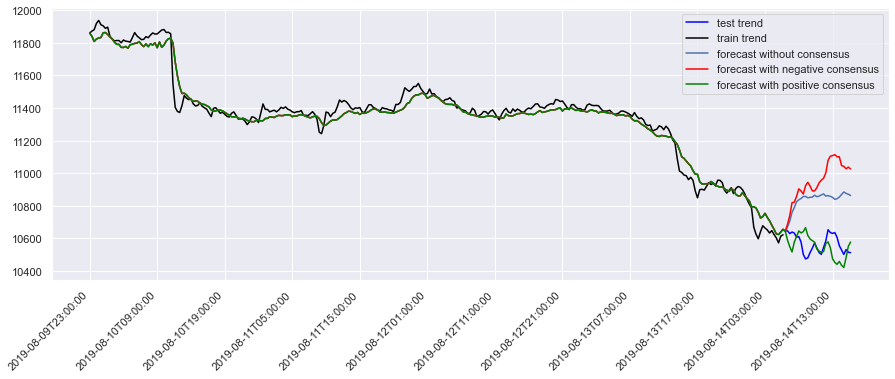

In [16]:
timestamp = df['timestamp'].tolist()
pad_test = np.pad(df_test[:,0], (df_train.shape[0], 0), 'constant', constant_values=np.nan)

plt.figure(figsize = (15, 5))
plt.plot(pad_test, label = 'test trend', c = 'blue')
plt.plot(df_train[:,0], label = 'train trend', c = 'black')
plt.plot(deep_future, label = 'forecast without consensus')
plt.plot(deep_future_negative, label = 'forecast with negative consensus', c = 'red')
plt.plot(deep_future_positive, label = 'forecast with positive consensus', c = 'green')
plt.legend()
plt.xticks(
    np.arange(len(timestamp))[::30], timestamp[::30], rotation = '45', ha = 'right'
)
plt.show()

## What we can observe

1. The model learn, if positive and negative sentiments increasing, both will increase the price. That is why, using positive consensus or negative consensus caused price going up.
2. Volatility of price is higher if negative sentiment is higher, still positive volatility.
3. Momentum of price is higher if negative sentiment is higher, still positive momentum.